20220920
Multilayer perceptron을 이용한 예측
- origin

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

import torch
print(torch.cuda.is_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2, 3"  # Set the GPUs 2 and 3 to use

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

import matplotlib.pyplot as plt

True
Device: cuda
Current cuda device: 0
Count of using GPUs: 4


In [14]:
%matplotlib inline

df = pd.read_csv('../data_up_delta.csv')
df.head()

,Unnamed: 0,receve comp time,printing start time,printing comp time,cutting start time,cutting comp time,pac time,T1,T2,T3,...,T5,X1,X2,X3,X4,Y0,X1_d1,X3_d1,X1_d2,X3_d2
0,2,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
1,3,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
2,4,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
3,5,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
4,6,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0


In [15]:
input_data = pd.DataFrame()
input_data[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X1_d2', 'X3_d1', 'X3_d2','Y0']] = df[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X1_d2', 'X3_d1', 'X3_d2', 'Y0']]
input_data.head(5)

,receve comp time,X1,X2,X3,X4,X1_d1,X1_d2,X3_d1,X3_d2,Y0
0,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,140.0,70.0,70.0,540.0
1,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,140.0,70.0,70.0,540.0
2,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,140.0,70.0,70.0,540.0
3,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,140.0,70.0,70.0,540.0
4,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,140.0,70.0,70.0,540.0


In [16]:
# 데이터 프레임.info() 함수는 데이터프레임에 관한 정보
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receve comp time  16992 non-null  object 
 1   X1                16992 non-null  float64
 2   X2                16992 non-null  float64
 3   X3                16992 non-null  float64
 4   X4                16992 non-null  float64
 5   X1_d1             16992 non-null  float64
 6   X1_d2             16992 non-null  float64
 7   X3_d1             16992 non-null  float64
 8   X3_d2             16992 non-null  float64
 9   Y0                16992 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


X1, X2, X3, X4 의 평균 구하기 추정할 때, 값이 없을 경우 평균으로 입력

In [17]:
X1_mean = df['X1'].mean()
X2_mean = df['X2'].mean()
X3_mean = df['X3'].mean()
X4_mean = df['X4'].mean()
Y0_mean = df['Y0'].mean()

X1_d1_mean = df['X1_d1'].mean()
X1_d2_mean = df['X1_d2'].mean()
X3_d1_mean = df['X3_d1'].mean()
X3_d2_mean = df['X3_d2'].mean()
print('X1 mean={:.2f}, X2 mean={:.2f}, X3 mean={:.2f}, X4 mean={:.2f}'.format(X1_mean, X2_mean, X3_mean, X4_mean))
print('X1_d1 mean={:.2f}, X1_d2 mean={:.2f}, X3_d1 mean={:.2f}, X3_d2 mean={:.2f}'.format(X1_d1_mean, X1_d2_mean, X3_d1_mean, X3_d2_mean))

X1 mean=123.99, X2 mean=5.05, X3 mean=130.89, X4 mean=10.54
X1_d1 mean=123.99, X1_d2 mean=124.00, X3_d1 mean=130.89, X3_d2 mean=130.89


In [18]:
# 데이터 셋을 target 기준으로 분리. Y0가 예측하려고 하는 값, X1, X2, X3 입력 변수 값
X = df[['X1','X2','X3', 'X4', 'X1_d1', 'X1_d2', 'X3_d1', 'X3_d2']].values
y = df['Y0'].values
print(X.shape, type(X))
print(y.shape, type(y))

(16992, 8) <class 'numpy.ndarray'>
(16992,) <class 'numpy.ndarray'>


In [19]:
# 80% training, 20% test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(13593, 8) (13593,)
(3399, 8) (3399,)


In [78]:
x3_pre = pd.DataFrame(x_test)
x3_pre.columns = ['X1', 'X2', 'X3', 'X4', 'X1_d1', 'X1_d2', 'X3_d1', 'X3_d2']
x3_pre = x3_pre[['X3']]
x3_push = pd.DataFrame()
x3_push[['X3']] = x3_pre.iloc[:1]
x3_push = x3_push.append(x3_pre)
x3_push = x3_push.iloc[:-1]
x3_push = x3_push['X3'].to_numpy()
x3_push

array([ 0.,  0., 31., ...,  1., 40., 47.])

데이터를 tensor 데이터형으로 변환

In [20]:
x_train_seq = torch.FloatTensor(x_train)
y_train_seq = torch.FloatTensor(y_train).view([-1, 1])
x_test_seq = torch.FloatTensor(x_test)
y_test_seq = torch.FloatTensor(y_test).view([-1, 1])
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([13593, 8]) torch.Size([13593, 1])
torch.Size([3399, 8]) torch.Size([3399, 1])


In [21]:
x_train_seq = x_train_seq.to(device)
y_train_seq = y_train_seq.to(device)
x_test_seq =  x_test_seq.to(device)
y_test_seq = y_test_seq.to(device)
print(x_train_seq.is_cuda)

True


data loader 만들기

In [22]:
# 배치 형태로 만들어 주자. 시계열이니까 셔플을 막 하면 안된다
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)  # x_train 과 y_train 은 하나의 TensorDataset 으로 결합
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [23]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

모델 만들기

In [24]:
relu = nn.ReLU()
linear1 = nn.Linear(8, 64, bias=True)
linear2 = nn.Linear(64, 512, bias=True)
linear3 = nn.Linear(512, 1024, bias=True)
linear33 = nn.Linear(1024, 2048, bias=True)
linear4 = nn.Linear(2048, 512, bias=True)
linear5 = nn.Linear(512, 32, bias=True)
linear6 = nn.Linear(32, 1, bias=True)

nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear33.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)
nn.init.xavier_uniform_(linear6.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3, relu,
    linear33, relu,
    linear4, relu,
    linear5, relu,
    linear6
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=1, bias=True)
)


In [25]:
model.to(device)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
import time
import os
import datetime
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


num_epochs = 1000
batch_size = 50
learning_r = 1e-3
pwd = os.getcwd()
print(pwd)
model_name = os.path.join(pwd,'model/mlp-data_up_delta1.model')
figure_name = os.path.join(pwd,'result/mlp-data_up_delta1.png')
print(model_name, figure_name)

def training(model, train_dataloader):
    print("\nTraining is Started ")
    model.train()
    criterion = nn.MSELoss()       
    optimizer = optim.Adam(model.parameters(), lr=learning_r)  

    start_time = time.time()
    loss_graph = [] # 그래프 그릴 목적인 loss.
    n = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.
        for data in train_loader:
            seq, target = data
            out = model(seq) 
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_graph.append(running_loss / n)
        if epoch % 10 == 0:
            print('[epoch: {}] loss: {:.4f}   Time: {}'.format(epoch, running_loss/n, datetime.datetime.now()))
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)
    plt.show()
    plt.savefig(figure_name)

    torch.save(model.state_dict(), model_name)
    print('    model_path={} is saved'.format(model_name))
    return


/sharehouse/DATA/SMART_FACTORY/ckim
/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta1.model /sharehouse/DATA/SMART_FACTORY/ckim/result/mlp-data_up_delta1.png


In [46]:
# err_range = 10.  # error range in hit ratio
def testing(model, test_loader, err_range): # all values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    print(test_pred[10:20])
    print(test_actual[10:20])
    
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [47]:
def testing2(model, test_loader, x2, x3, x4, x1_d1, x1_d2, x3_d1, x3_d2, err_range): # X1, All mean values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          seq[:,1] = x2
          seq[:,2] = x3
          seq[:,3] = x4
          seq[:,4] = x1_d1
          seq[:,5] = x1_d2
          seq[:,6] = x3_d1
          seq[:,7] = x3_d2
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [66]:
def testing3(model, test_loader, x2, x3, x4, x1_d1, x1_d2, x3_d1, x3_d2, err_range): # X1, X2 mean, X3 previous value, X4 mean / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data, x3_pre in zip(test_loader, x3):
          seq, target = data
          #print(seq)
          seq[:,1] = x2
          seq[:,2] = x3_pre
          seq[:,3] = x4
          #print('---> ', seq)
        
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
            
          x3_pre = x3
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

  0%|          | 0/1000 [00:00<?, ?it/s]


Training is Started 


  0%|          | 1/1000 [00:01<30:57,  1.86s/it]

[epoch: 0] loss: 20140.0332   Time: 2022-09-20 17:11:20.378341


  1%|          | 11/1000 [00:17<25:47,  1.56s/it]

[epoch: 10] loss: 1010.1113   Time: 2022-09-20 17:11:36.002396


  2%|▏         | 21/1000 [00:33<25:57,  1.59s/it]

[epoch: 20] loss: 158.8342   Time: 2022-09-20 17:11:51.779825


  3%|▎         | 31/1000 [00:48<25:13,  1.56s/it]

[epoch: 30] loss: 171.3422   Time: 2022-09-20 17:12:07.414234


  4%|▍         | 41/1000 [01:04<24:54,  1.56s/it]

[epoch: 40] loss: 19.4789   Time: 2022-09-20 17:12:23.021428


  5%|▌         | 51/1000 [01:20<24:44,  1.56s/it]

[epoch: 50] loss: 77.5258   Time: 2022-09-20 17:12:38.705304


  6%|▌         | 61/1000 [01:35<24:03,  1.54s/it]

[epoch: 60] loss: 14.0735   Time: 2022-09-20 17:12:54.187665


  7%|▋         | 71/1000 [01:49<23:31,  1.52s/it]

[epoch: 70] loss: 107.0271   Time: 2022-09-20 17:13:08.326287


  8%|▊         | 81/1000 [02:05<23:47,  1.55s/it]

[epoch: 80] loss: 16.3197   Time: 2022-09-20 17:13:23.882686


  9%|▉         | 91/1000 [02:21<24:39,  1.63s/it]

[epoch: 90] loss: 10.4581   Time: 2022-09-20 17:13:39.877146


 10%|█         | 101/1000 [02:36<23:23,  1.56s/it]

[epoch: 100] loss: 75.6335   Time: 2022-09-20 17:13:55.494285


 11%|█         | 111/1000 [02:52<23:06,  1.56s/it]

[epoch: 110] loss: 11.9493   Time: 2022-09-20 17:14:11.095579


 12%|█▏        | 121/1000 [03:08<22:50,  1.56s/it]

[epoch: 120] loss: 4.0299   Time: 2022-09-20 17:14:26.691169


 13%|█▎        | 131/1000 [03:23<22:35,  1.56s/it]

[epoch: 130] loss: 3.4693   Time: 2022-09-20 17:14:42.280592


 14%|█▍        | 141/1000 [03:39<22:08,  1.55s/it]

[epoch: 140] loss: 3.0775   Time: 2022-09-20 17:14:57.769275


 15%|█▌        | 151/1000 [03:54<21:54,  1.55s/it]

[epoch: 150] loss: 25.3445   Time: 2022-09-20 17:15:13.242769


 16%|█▌        | 161/1000 [04:10<21:38,  1.55s/it]

[epoch: 160] loss: 135.4624   Time: 2022-09-20 17:15:28.707503


 17%|█▋        | 171/1000 [04:25<21:19,  1.54s/it]

[epoch: 170] loss: 13.6793   Time: 2022-09-20 17:15:44.057484


 18%|█▊        | 181/1000 [04:41<21:10,  1.55s/it]

[epoch: 180] loss: 1.4059   Time: 2022-09-20 17:15:59.552035


 19%|█▉        | 191/1000 [04:56<20:59,  1.56s/it]

[epoch: 190] loss: 1.5912   Time: 2022-09-20 17:16:15.101121


 20%|██        | 201/1000 [05:12<20:49,  1.56s/it]

[epoch: 200] loss: 707.0554   Time: 2022-09-20 17:16:30.738271


 21%|██        | 211/1000 [05:27<20:28,  1.56s/it]

[epoch: 210] loss: 95.7477   Time: 2022-09-20 17:16:46.335888


 22%|██▏       | 221/1000 [05:43<20:08,  1.55s/it]

[epoch: 220] loss: 3.6613   Time: 2022-09-20 17:17:01.876586


 23%|██▎       | 231/1000 [05:58<19:43,  1.54s/it]

[epoch: 230] loss: 1.1746   Time: 2022-09-20 17:17:17.284711


 24%|██▍       | 241/1000 [06:14<19:28,  1.54s/it]

[epoch: 240] loss: 3.1739   Time: 2022-09-20 17:17:32.671551


 25%|██▌       | 251/1000 [06:29<19:17,  1.55s/it]

[epoch: 250] loss: 1.4622   Time: 2022-09-20 17:17:48.108509


 26%|██▌       | 261/1000 [06:45<19:05,  1.55s/it]

[epoch: 260] loss: 1.5325   Time: 2022-09-20 17:18:03.626891


 27%|██▋       | 271/1000 [06:59<16:41,  1.37s/it]

[epoch: 270] loss: 6.0402   Time: 2022-09-20 17:18:18.304678


 28%|██▊       | 281/1000 [07:15<19:23,  1.62s/it]

[epoch: 280] loss: 229.9233   Time: 2022-09-20 17:18:33.618640


 29%|██▉       | 291/1000 [07:31<19:22,  1.64s/it]

[epoch: 290] loss: 9.2814   Time: 2022-09-20 17:18:50.004659


 30%|███       | 301/1000 [07:47<19:13,  1.65s/it]

[epoch: 300] loss: 1014.7804   Time: 2022-09-20 17:19:06.502445


 31%|███       | 311/1000 [08:04<18:52,  1.64s/it]

[epoch: 310] loss: 9.9528   Time: 2022-09-20 17:19:22.938159


 32%|███▏      | 321/1000 [08:19<16:21,  1.45s/it]

[epoch: 320] loss: 5.4494   Time: 2022-09-20 17:19:38.499314


 33%|███▎      | 331/1000 [08:35<17:14,  1.55s/it]

[epoch: 330] loss: 11.6167   Time: 2022-09-20 17:19:53.776237


 34%|███▍      | 341/1000 [08:49<16:53,  1.54s/it]

[epoch: 340] loss: 61.2704   Time: 2022-09-20 17:20:08.288052


 35%|███▌      | 351/1000 [09:05<17:05,  1.58s/it]

[epoch: 350] loss: 1.3085   Time: 2022-09-20 17:20:24.429708


 36%|███▌      | 361/1000 [09:21<16:38,  1.56s/it]

[epoch: 360] loss: 1.6402   Time: 2022-09-20 17:20:40.020383


 37%|███▋      | 371/1000 [09:35<15:30,  1.48s/it]

[epoch: 370] loss: 1.7382   Time: 2022-09-20 17:20:54.485943


 38%|███▊      | 381/1000 [09:51<15:54,  1.54s/it]

[epoch: 380] loss: 7.2166   Time: 2022-09-20 17:21:09.909594


 39%|███▉      | 391/1000 [10:06<14:45,  1.45s/it]

[epoch: 390] loss: 11.0024   Time: 2022-09-20 17:21:25.341557


 40%|████      | 401/1000 [10:18<12:10,  1.22s/it]

[epoch: 400] loss: 166.9984   Time: 2022-09-20 17:21:37.469879


 41%|████      | 411/1000 [10:32<12:46,  1.30s/it]

[epoch: 410] loss: 76.0338   Time: 2022-09-20 17:21:50.530134


 42%|████▏     | 421/1000 [10:45<12:32,  1.30s/it]

[epoch: 420] loss: 1.0456   Time: 2022-09-20 17:22:03.541212


 43%|████▎     | 431/1000 [10:58<12:29,  1.32s/it]

[epoch: 430] loss: 1.9020   Time: 2022-09-20 17:22:16.982920


 44%|████▍     | 441/1000 [11:11<12:38,  1.36s/it]

[epoch: 440] loss: 10.4649   Time: 2022-09-20 17:22:30.356851


 45%|████▌     | 451/1000 [11:24<11:34,  1.26s/it]

[epoch: 450] loss: 19.8343   Time: 2022-09-20 17:22:43.045802


 46%|████▌     | 461/1000 [11:38<13:22,  1.49s/it]

[epoch: 460] loss: 50.7845   Time: 2022-09-20 17:22:57.083329


 47%|████▋     | 471/1000 [11:53<13:22,  1.52s/it]

[epoch: 470] loss: 1.5508   Time: 2022-09-20 17:23:12.125539


 48%|████▊     | 481/1000 [12:10<13:53,  1.61s/it]

[epoch: 480] loss: 2.9007   Time: 2022-09-20 17:23:29.119595


 49%|████▉     | 491/1000 [12:25<12:46,  1.51s/it]

[epoch: 490] loss: 1.3578   Time: 2022-09-20 17:23:44.412232


 50%|█████     | 501/1000 [12:41<12:47,  1.54s/it]

[epoch: 500] loss: 29.3855   Time: 2022-09-20 17:24:00.137054


 51%|█████     | 511/1000 [12:55<11:28,  1.41s/it]

[epoch: 510] loss: 1.9761   Time: 2022-09-20 17:24:14.207104


 52%|█████▏    | 521/1000 [13:11<12:35,  1.58s/it]

[epoch: 520] loss: 1.0638   Time: 2022-09-20 17:24:30.449276


 53%|█████▎    | 531/1000 [13:28<12:50,  1.64s/it]

[epoch: 530] loss: 1.8911   Time: 2022-09-20 17:24:46.787690


 54%|█████▍    | 541/1000 [13:44<12:42,  1.66s/it]

[epoch: 540] loss: 3.0532   Time: 2022-09-20 17:25:03.283378


 55%|█████▌    | 551/1000 [14:01<12:31,  1.67s/it]

[epoch: 550] loss: 1.9604   Time: 2022-09-20 17:25:20.365391


 56%|█████▌    | 561/1000 [14:18<12:35,  1.72s/it]

[epoch: 560] loss: 1.0828   Time: 2022-09-20 17:25:37.123388


 57%|█████▋    | 571/1000 [14:35<12:08,  1.70s/it]

[epoch: 570] loss: 1.8979   Time: 2022-09-20 17:25:53.552958


 58%|█████▊    | 581/1000 [14:51<10:59,  1.57s/it]

[epoch: 580] loss: 0.9920   Time: 2022-09-20 17:26:09.713882


 59%|█████▉    | 591/1000 [15:06<10:38,  1.56s/it]

[epoch: 590] loss: 8.4116   Time: 2022-09-20 17:26:25.325674


 60%|██████    | 601/1000 [15:22<10:22,  1.56s/it]

[epoch: 600] loss: 2.0407   Time: 2022-09-20 17:26:40.923859


 61%|██████    | 611/1000 [15:37<10:07,  1.56s/it]

[epoch: 610] loss: 2.2840   Time: 2022-09-20 17:26:56.500484


 62%|██████▏   | 621/1000 [15:53<09:52,  1.56s/it]

[epoch: 620] loss: 2.9590   Time: 2022-09-20 17:27:12.133326


 63%|██████▎   | 631/1000 [16:09<09:35,  1.56s/it]

[epoch: 630] loss: 266.3256   Time: 2022-09-20 17:27:27.744497


 64%|██████▍   | 641/1000 [16:24<09:20,  1.56s/it]

[epoch: 640] loss: 4.7359   Time: 2022-09-20 17:27:43.346627


 65%|██████▌   | 651/1000 [16:40<09:09,  1.57s/it]

[epoch: 650] loss: 260.6237   Time: 2022-09-20 17:27:59.094533


 66%|██████▌   | 661/1000 [16:56<08:50,  1.57s/it]

[epoch: 660] loss: 3.3053   Time: 2022-09-20 17:28:14.734213


 67%|██████▋   | 671/1000 [17:11<08:27,  1.54s/it]

[epoch: 670] loss: 295.3274   Time: 2022-09-20 17:28:30.199008


 68%|██████▊   | 681/1000 [17:27<08:08,  1.53s/it]

[epoch: 680] loss: 1.6988   Time: 2022-09-20 17:28:45.533712


 69%|██████▉   | 691/1000 [17:42<07:56,  1.54s/it]

[epoch: 690] loss: 2.0410   Time: 2022-09-20 17:29:00.893786


 70%|███████   | 701/1000 [17:57<07:41,  1.54s/it]

[epoch: 700] loss: 2.4468   Time: 2022-09-20 17:29:16.322780


 71%|███████   | 711/1000 [18:13<07:26,  1.55s/it]

[epoch: 710] loss: 170.1159   Time: 2022-09-20 17:29:31.758025


 72%|███████▏  | 721/1000 [18:28<07:12,  1.55s/it]

[epoch: 720] loss: 9.7739   Time: 2022-09-20 17:29:47.242724


 73%|███████▎  | 731/1000 [18:44<06:56,  1.55s/it]

[epoch: 730] loss: 1.1198   Time: 2022-09-20 17:30:02.750714


 74%|███████▍  | 741/1000 [18:59<06:40,  1.55s/it]

[epoch: 740] loss: 7.3566   Time: 2022-09-20 17:30:18.217072


 75%|███████▌  | 751/1000 [19:15<06:25,  1.55s/it]

[epoch: 750] loss: 1.7259   Time: 2022-09-20 17:30:33.698755


 76%|███████▌  | 761/1000 [19:30<06:05,  1.53s/it]

[epoch: 760] loss: 1.7474   Time: 2022-09-20 17:30:49.097429


 77%|███████▋  | 771/1000 [19:46<05:53,  1.54s/it]

[epoch: 770] loss: 2.0355   Time: 2022-09-20 17:31:04.541273


 78%|███████▊  | 781/1000 [20:01<05:37,  1.54s/it]

[epoch: 780] loss: 1.2855   Time: 2022-09-20 17:31:19.980460


 79%|███████▉  | 791/1000 [20:16<05:22,  1.54s/it]

[epoch: 790] loss: 4.5111   Time: 2022-09-20 17:31:35.412849


 80%|████████  | 801/1000 [20:32<04:48,  1.45s/it]

[epoch: 800] loss: 6.4383   Time: 2022-09-20 17:31:50.524300


 81%|████████  | 811/1000 [20:47<04:52,  1.55s/it]

[epoch: 810] loss: 1.6932   Time: 2022-09-20 17:32:05.813226


 82%|████████▏ | 821/1000 [21:02<04:35,  1.54s/it]

[epoch: 820] loss: 157.3940   Time: 2022-09-20 17:32:21.295431


 83%|████████▎ | 831/1000 [21:17<04:19,  1.53s/it]

[epoch: 830] loss: 2.2799   Time: 2022-09-20 17:32:35.996451


 84%|████████▍ | 841/1000 [21:32<04:06,  1.55s/it]

[epoch: 840] loss: 2.2912   Time: 2022-09-20 17:32:51.500058


 85%|████████▌ | 851/1000 [21:48<03:49,  1.54s/it]

[epoch: 850] loss: 2.0825   Time: 2022-09-20 17:33:06.942742


 86%|████████▌ | 861/1000 [22:03<03:34,  1.54s/it]

[epoch: 860] loss: 20.7852   Time: 2022-09-20 17:33:22.360050


 87%|████████▋ | 871/1000 [22:19<03:18,  1.54s/it]

[epoch: 870] loss: 5.0154   Time: 2022-09-20 17:33:37.756848


 88%|████████▊ | 881/1000 [22:34<03:04,  1.55s/it]

[epoch: 880] loss: 26.7215   Time: 2022-09-20 17:33:53.235357


 89%|████████▉ | 891/1000 [22:50<02:49,  1.55s/it]

[epoch: 890] loss: 6.9489   Time: 2022-09-20 17:34:08.761961


 90%|█████████ | 901/1000 [23:05<02:33,  1.55s/it]

[epoch: 900] loss: 1.1022   Time: 2022-09-20 17:34:24.294194


 91%|█████████ | 911/1000 [23:21<02:18,  1.56s/it]

[epoch: 910] loss: 1.4410   Time: 2022-09-20 17:34:39.856525


 92%|█████████▏| 921/1000 [23:36<02:02,  1.55s/it]

[epoch: 920] loss: 2.9245   Time: 2022-09-20 17:34:55.391295


 93%|█████████▎| 931/1000 [23:52<01:47,  1.56s/it]

[epoch: 930] loss: 5.8251   Time: 2022-09-20 17:35:10.952082


 94%|█████████▍| 941/1000 [24:08<01:32,  1.56s/it]

[epoch: 940] loss: 7.2295   Time: 2022-09-20 17:35:26.589926


 95%|█████████▌| 951/1000 [24:23<01:16,  1.56s/it]

[epoch: 950] loss: 8.6087   Time: 2022-09-20 17:35:42.222045


 96%|█████████▌| 961/1000 [24:39<01:00,  1.56s/it]

[epoch: 960] loss: 1.1817   Time: 2022-09-20 17:35:57.839659


 97%|█████████▋| 971/1000 [24:54<00:45,  1.56s/it]

[epoch: 970] loss: 2.9791   Time: 2022-09-20 17:36:13.457768


 98%|█████████▊| 981/1000 [25:10<00:29,  1.56s/it]

[epoch: 980] loss: 18.6741   Time: 2022-09-20 17:36:29.089143


 99%|█████████▉| 991/1000 [25:26<00:14,  1.56s/it]

[epoch: 990] loss: 85.9378   Time: 2022-09-20 17:36:44.717637


100%|██████████| 1000/1000 [25:43<00:00,  1.54s/it]


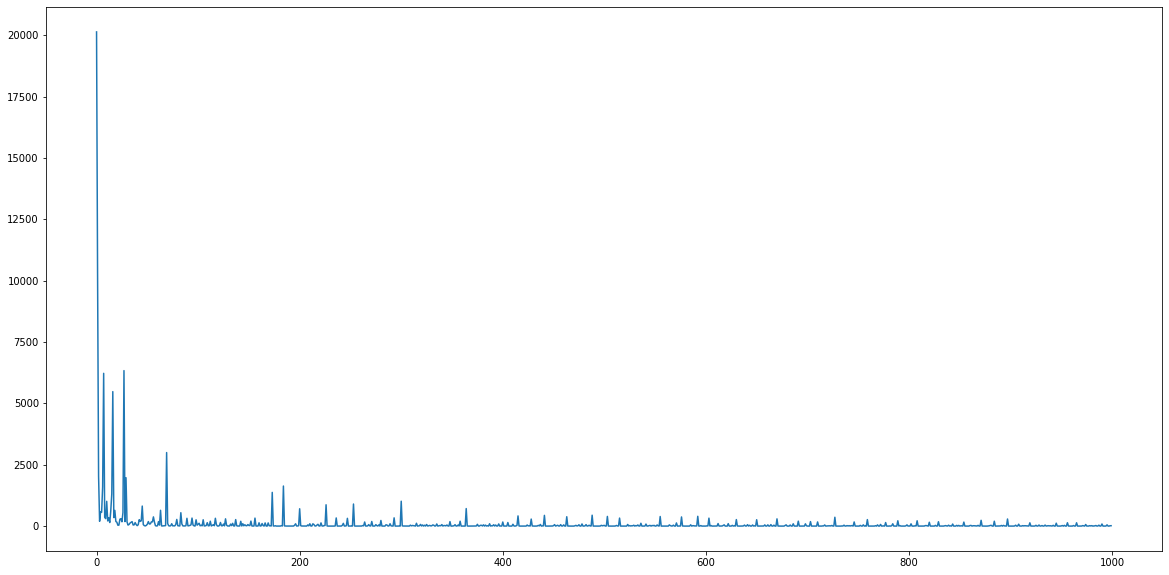

    model_path=/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta1.model is saved


<Figure size 432x288 with 0 Axes>

In [35]:
training(model, train_loader)

In [36]:
model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=1, bias=True)
)

In [37]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [49]:
testing(model, test_loader, 10.)
testing(model, test_loader, 30.)


Testing is Started 
model is loaded
3399 3399
[[237.07467651367188], [119.00670623779297], [140.0918426513672], [96.9326400756836], [383.193359375], [68.9903793334961], [742.4857788085938], [1456.999267578125], [109.98430633544922], [75.03355407714844]]
[[237.0], [119.0], [140.0], [97.0], [383.0], [69.0], [742.0], [1456.0], [110.0], [75.0]]
평균제곱근오차 1.6649305264423153
결정계수 0.9999835630626759
hit ratio with error range(10.00) = 0.9985, no of errors = 5, total = 3399

Testing is Started 
model is loaded
3399 3399
[[237.07467651367188], [119.00670623779297], [140.0918426513672], [96.9326400756836], [383.193359375], [68.9903793334961], [742.4857788085938], [1456.999267578125], [109.98430633544922], [75.03355407714844]]
[[237.0], [119.0], [140.0], [97.0], [383.0], [69.0], [742.0], [1456.0], [110.0], [75.0]]
평균제곱근오차 1.6649305264423153
결정계수 0.9999835630626759
hit ratio with error range(30.00) = 0.9994, no of errors = 2, total = 3399


In [56]:
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X1_d2_mean, X3_d1_mean, X3_d2_mean, 10.)
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X1_d2_mean, X3_d1_mean, X3_d2_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 369.3460054716267
결정계수 -11.426933047743237
hit ratio with error range(10.00) = 0.0430, no of errors = 3253, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 369.3460054716267
결정계수 -11.426933047743237
hit ratio with error range(30.00) = 0.1309, no of errors = 2954, total = 3399


In [79]:
testing3(model, test_loader, X2_mean, x3_push, X4_mean, X1_d1_mean, X1_d2_mean, X3_d1_mean, X3_d2_mean, 10.)
testing3(model, test_loader, X2_mean, x3_push, X4_mean, X1_d1_mean, X1_d2_mean, X3_d1_mean, X3_d2_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 422.86760378901187
결정계수 -2.2648441866109006
hit ratio with error range(10.00) = 0.1171, no of errors = 3001, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 422.86760378901187
결정계수 -2.2648441866109006
hit ratio with error range(30.00) = 0.3016, no of errors = 2374, total = 3399


In [52]:
ran = [200, 400, 600, 800, 1000]
for i in ran:
    print(i, x_test[i], y_test[i])
    print(i-1, x_test[i-1], y_test[i-1])
    print('    mean = ', x_test[i-5:i].mean(axis=0))
print()


200 [ 69.   5.  80.  10. 250.  60.  49.  62.] 164.0
199 [ 33.   5.  58.  10.  54.  79.  30. 129.] 106.0
    mean =  [ 59.8   5.  254.6  10.  140.4 182.8 259.8 126.4]
400 [136.   5. 304.  10.  77.  77. 128. 128.] 455.0
399 [ 58.   5.  30.  10. 150.  96. 156.   3.] 103.0
    mean =  [74.2  5.  66.6 10.  95.  68.  81.8 36.4]
600 [219.   5.  21.  10. 153. 287. 598.  12.] 255.00000000000003
599 [39.  5. 29. 10. 64. 88. 50. 52.] 83.0
    mean =  [188.    5.   79.6  10.   88.4  90.8  27.  917.2]
800 [ 57.   5.  63.  10.  57. 119.  63.  31.] 135.00000000000003
799 [89.  5. 37. 10. 89. 89. 37. 37.] 141.0
    mean =  [108.    5.   82.   10.  102.2 121.6  88.   98.4]
1000 [  45.    5.  107.   10.  175.   49. 1089.   16.] 167.0
999 [ 35.   5.  80.  10. 128.  35. 154.  80.] 130.00000000000003
    mean =  [113.8   5.  211.8  10.   82.6  80.4 236.  120. ]



Sample test

In [ ]:
X1_val = 169.
X2_val = 5.
X3_val = 13.
X4_val = 10.
Y0_val = 197.
X1_d1_val = 101.
X3_d1_val = 93.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
X1_d2_val = X1_d2_mean
X3_d2_val = X3_d2_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val, X1_d2_val, X3_d2_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])
X2_val = 5
X3_val = 18
X4_val = 10
X1_d1_val = 89
X3_d1_val = 18
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

In [39]:
X1_val = 29.
X2_val = 5.
X3_val = 28.
X4_val = 10.
Y0_val = 72.
X1_d1_val = 154.
X1_d2_val = 29.
X3_d1_val = 12.
X3_d2_val = 28.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 375.
X4_val = 10.
X1_d1_val = 48.
X3_d1_val = 57
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=29.00, X2=5.00, X3=28.00, X4=10.00, Y0=72.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [40]:
X1_val = 117.
X2_val = 5.
X3_val = 126.
X4_val = 10.
Y0_val = 258.
X1_d1_val = 76.
X3_d1_val = 17.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 105.
X4_val = 10.
X1_d1_val = 122.
X1_d2_val = 66.
X3_d1_val = 85.
X3_d2_val = 9.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=117.00, X2=5.00, X3=126.00, X4=10.00, Y0=258.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [41]:
X1_val = 95.
X2_val = 5.
X3_val = 6.
X4_val = 10.
Y0_val = 116.
X1_d1_val = 175.
X3_d1_val = 11.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val, X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 17.
X4_val = 10.
X1_d1_val = 167.
X3_d1_val = 17.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=95.00, X2=5.00, X3=6.00, X4=10.00, Y0=116.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [42]:
X1_val = 152.
X2_val = 5.
X3_val = 55.
X4_val = 10.
Y0_val = 222.
X1_d1_val = 282.
X3_d1_val = 259.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 55.
X4_val = 10.
X1_d1_val = 382.
X3_d1_val = 359.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=152.00, X2=5.00, X3=55.00, X4=10.00, Y0=222.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)